#### Import packages and initialize the h2o application server

In [1]:
import h2o
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import time

from h2o.automl import H2OAutoML
from IPython.core.display import display, HTML

h2o.init(log_level="INFO")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.20.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.20.04, mixed mode, sharing)
  Starting server from /home/jeff/automl/env/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5trub8oz
  JVM stdout: /tmp/tmp5trub8oz/h2o_jeff_started_from_python.out
  JVM stderr: /tmp/tmp5trub8oz/h2o_jeff_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_jeff_1uygge
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.947 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


#### Load the data

In [2]:
current_customers = pd.read_json('Telco_Churn_current_customers.json')
historical_outcomes = pd.read_json('Telco_Churn_historical_outcomes.json')

history = h2o.H2OFrame(historical_outcomes)
curr = h2o.H2OFrame(current_customers)

all_columns = history.columns

# create a list of column names that should not be used as predictors (IDs, row counts, and the response column)
ignore_columns = ["customerID"]
for i in all_columns:
    if i[0:12] == "Row Count - ":
        ignore_columns.append(i)
print("Ignore Fields: " + str(ignore_columns))

# define the response (target) field
response = "Churn"

print(history.describe()) 

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Ignore Fields: ['customerID']
Rows:3522
Cols:21




,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
type,string,enum,int,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,real,enum
mins,NaN,,0.0,,,0.0,,,,,,,,,,,,,18.25,18.8,
mean,NaN,,0.16609880749574105,,,32.49318568994902,,,,,,,,,,,,,64.84890687109596,2304.3514634839453,
maxs,NaN,,1.0,,,72.0,,,,,,,,,,,,,118.75,8684.8,
sigma,NaN,,0.3722221539599785,,,24.748920014400024,,,,,,,,,,,,,30.283503060162047,2292.926936794687,
zeros,0,,2937,,,3,,,,,,,,,,,,,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
0,9018-PCIOK,Female,0.0,No,No,55.0,Yes,No,DSL,No,Yes,Yes,No,No,Yes,Two year,Yes,Mailed check,64.75,3617.1,No
1,6732-FZUGP,Female,0.0,No,No,47.0,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,No,One year,No,Credit card (automatic),94.9,4615.25,No
2,0623-EJQEG,Male,0.0,No,No,65.0,Yes,Yes,Fiber optic,Yes,No,No,Yes,No,Yes,One year,No,Electronic check,93.55,6069.25,No


None


#### Define model inputs, split into training and validation sets, train & validate the model

How long should we allow the model to build? (in seconds)  60
AutoML progress: |
20:20:37.8: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%
model build time (seconds): 69


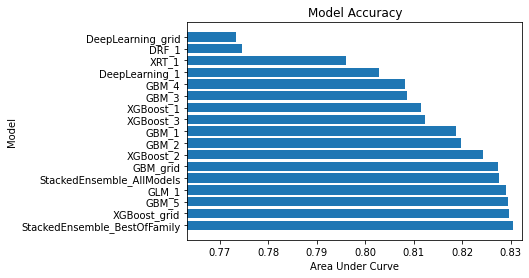

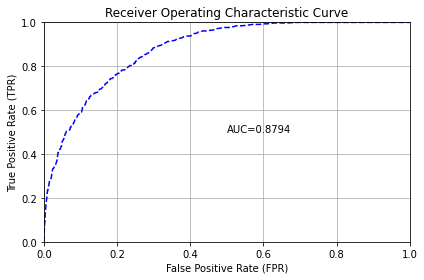


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29696925946763036: 


,,No,Yes,Error,Rate
0,No,1690.0,375.0,0.1816,(375.0/2065.0)
1,Yes,198.0,575.0,0.2561,(198.0/773.0)
2,Total,1888.0,950.0,0.2019,(573.0/2838.0)


In [3]:
runtime = int(input("How long should we allow the model to build? (in seconds)  "))

# define the predictors (include factors)
predictors = set(all_columns).difference(ignore_columns)
predictors = list(predictors)

for i in predictors:
    if i == response:
        predictors.remove(i)
        
# define training and validation splits
history[response] = history[response].asfactor()  # for binary classification, response should be cast as a factor
train, valid = history.split_frame(ratios=[.8], seed=1234)

# build the model
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
m = H2OAutoML(max_runtime_secs=runtime, max_models=40, seed=5678)

start_time = time.time()
m.train(x=predictors, y=response, training_frame=train, validation_frame=valid)
finish_time = time.time()
print("model build time (seconds): " + str(int(finish_time - start_time)))

# validate model accuracy using the leaderboard
lb = m.leaderboard.as_data_frame()
lb.sort_values(by="auc", ascending=True)
use_models = lb["model_id"].tolist()
use_performance = lb["auc"].tolist()

# iterate thru the model names for readability
for index,item in enumerate(use_models):
    use_models[index] = use_models[index][:use_models[index].replace("_", " ", 1).find("_")]  # trim the model name starting with the second underscore

plt.barh(use_models, use_performance)
plt.xlim(min(use_performance)-.01, max(use_performance)+.002)
plt.title("Model Accuracy")
plt.xlabel("Area Under Curve")
plt.ylabel("Model")
display(HTML("<a href='http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science.html#supervised'>Model Descriptions</a>"))
plt.show()

m_performance = m.leader.model_performance()
m_performance.plot(type="roc")

print(m.leader.confusion_matrix())

#### Score current customers

In [4]:
# score current current customers for churn using the highest performing model
predict = m.leader.predict(curr)

# bind the prediction to the original dataset and convert to a dataframe
curr = curr.cbind(predict)
current_customers_df = pd.DataFrame(curr.as_data_frame(), columns=curr.names)
all_columns = current_customers_df.columns
for i in all_columns:
    if i[0:12] == "Row Count - ":
        del current_customers_df[i]
print(current_customers_df.loc[:10,["customerID","predict","No","Yes"]])

current_customers.to_json('scored_customers.json')

h2o.cluster().shutdown()

stackedensemble prediction progress: |████████████████████████████████████| 100%
    customerID predict        No       Yes
0   3668-QPYBK     Yes  0.715177  0.284823
1   7795-CFOCW      No  0.933015  0.066985
2   9305-CDSKC     Yes  0.167719  0.832281
3   6713-OKOMC      No  0.806307  0.193693
4   9763-GRSKD      No  0.828981  0.171019
5   8091-TTVAX      No  0.836012  0.163988
6   9959-WOFKT      No  0.903209  0.096791
7   4190-MFLUW      No  0.836908  0.163092
8   8779-QRDMV     Yes  0.270006  0.729994
9   3638-WEABW      No  0.933199  0.066801
10  6865-JZNKO      No  0.848938  0.151062
H2O session _sid_a41c closed.
